# Mentorship: Productivity

This notebook digs into the effect access to a mentor has on productivity. When we measure this across all namespaces, we'll both include and exclude mentor questions. We'll also measure this for constructive Article & Talk namespace edits.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

library(countreg)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [3]:
## Path to the dataset with user information
user_dataset_filename <- here('datasets', 'mentorship_users.tsv')

## Column types in the user info dataset:
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers or doubles
user_dataset_column_types <- 'ficffiiflldd'

## Path to the dataset with Welcome Survey responses
survey_dataset_filename <- here('datasets', 'mentorship_survey_responses.tsv')

## Column types in the survey response dataset
survey_dataset_column_types <- 'fifffd'

## Path to the dataset with mentorship question edit data
mentor_edit_dataset_filename <- here('datasets', 'mentorship_edits.tsv')

## Column types in the mentorship question edit data
## We're skipping columns 8 & 9 because wiki_db and user_id are duplicated
mentor_edit_dataset_column_types <- 'ficffdd__iici'

## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'mentorship_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffddiiiiiiiiiiiiiiii'

# Data import and setup

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
        platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
        has_mentor = ifelse(mentor_enabled == 1, TRUE, FALSE),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        num_total_edits_24hrs_no_mentor = num_total_edits_24hrs - num_mentorship_edits_24hrs,
        num_total_edits_2w_no_mentor = num_total_edits_2w - num_mentorship_edits_2w,
        num_total_edits_no_mentor = num_total_edits_24hrs_no_mentor + num_total_edits_2w_no_mentor,
        # Counts of constructive article edits:
        num_const_article_edits = num_article_edits_24hrs + num_article_edits_2w -
                                    num_article_reverts_24hrs - num_article_reverts_2w,
        num_const_article_edits_24hrs = num_article_edits_24hrs - num_article_reverts_24hrs,
        num_const_article_edits_2w = num_article_edits_2w - num_article_reverts_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Did they activate through mentorship?
        is_activated_mentor = num_mentorship_edits_24hrs > 0,
        # Did they activate for other reasons than asking their mentor?
        is_activated_no_mentor = num_total_edits_24hrs_no_mentor > 0,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [6]:
nrow(editing_data)

[1] 133832

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
editing_data %>%
    group_by(wiki_db, platform, mentor_enabled) %>%
    summarize(n = n())

We filter out users with `mentor_enabled` set to 2 because they're so few of them. I suspect they disabled mentorship themselves.

In [8]:
editing_data <- editing_data |>
    filter(mentor_enabled < 2)

In [ ]:
editing_data |>
    group_by(wiki_db, platform, mentor_enabled) |>
    summarize(n = n()) |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

In [10]:
editing_data |>
    group_by(wiki_db, mentor_enabled) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

wiki_db mentor_enabled n      per_group perc
1 enwiki  0              101742 114512    88.8
2 enwiki  1               12770 114512    11.2
3 eswiki  0                9646  19305    50.0
4 eswiki  1                9659  19305    50.0

# Productivity Statistics

In [11]:
editing_data |>
    group_by(wiki_name, platform_name, has_mentor) |>
    summarize(mean_total_edits = mean(num_total_edits), median_total_edits = median(num_total_edits),
              mean_constr_article_edits = mean(num_const_article_edits),
              median_constr_article_edits = median(num_const_article_edits),
              q75_constr_article_edits = quantile(num_const_article_edits, 0.75),
              q90_constr_article_edits = quantile(num_const_article_edits, 0.9),
              q95_constr_article_edits = quantile(num_const_article_edits, 0.95),
              geomean_constr_article_edits = mean(exp(log(1 + num_const_article_edits))) - 1
             )

`summarise()` has grouped output by 'wiki_name', 'platform_name'. You can
override using the `.groups` argument.


wiki_name platform_name has_mentor mean_total_edits median_total_edits
1 English   Desktop       FALSE      1.95             0                 
2 English   Desktop        TRUE      2.32             0                 
3 English   Mobile web    FALSE      1.55             0                 
4 English   Mobile web     TRUE      1.49             0                 
5 Spanish   Desktop       FALSE      1.85             0                 
6 Spanish   Desktop        TRUE      1.85             0                 
7 Spanish   Mobile web    FALSE      1.87             0                 
8 Spanish   Mobile web     TRUE      1.61             0                 
  mean_constr_article_edits median_constr_article_edits
1 1.008                     0                          
2 1.419                     0                          
3 0.814                     0                          
4 0.768                     0                          
5 1.205                     0                          
6 1.179                     0                          
7 1.096                     0                          
8 0.830                     0                          
  q75_constr_article_edits q90_constr_article_edits q95_constr_article_edits
1 0                        2                        3                       
2 0                        2                        4                       
3 0                        1                        3                       
4 0                        1                        2                       
5 1                        2                        4                       
6 1                        2                        5                       
7 0                        2                        3                       
8 0                        2                        3                       
  geomean_constr_article_edits
1 1.008                       
2 1.419                       
3 0.814                       
4 0.768                       
5 1.205                       
6 1.179                       
7 1.096                       
8 0.830

# Overall productivity

We measure this on a per-wiki basis. In previous analyses, we've used mixed-effects models for this, but since we only have two wikis, such a model is unlikely to provide useful insights.

## English Wikipedia

In [12]:
blas_set_num_threads(16)
enwiki.overall.edits.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [13]:
summary(enwiki.overall.edits.model.1)


Call:
zeroinfl(formula = num_total_edits ~ platform + has_mentor | platform, 
    data = filter(editing_data, wiki_db == "enwiki"), dist = "negbin", 
    link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.419  -0.417  -0.412  -0.143 235.699 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      0.42587    0.01199   35.53 < 0.0000000000000002 ***
platformdesktop  0.24951    0.01479   16.87 < 0.0000000000000002 ***
has_mentorTRUE   0.10030    0.02253    4.45            0.0000085 ***
Log(theta)      -1.65761    0.00635 -261.11 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
                Estimate Std. Error z value Pr(>|z|)
(Intercept)       -14.59      42.54   -0.34     0.73
platformdesktop    -1.71      81.05   -0.02     0.98
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.191 
Number of iterations in BF

In [14]:
blas_set_num_threads(16)
enwiki.overall.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [15]:
summary(enwiki.overall.edits.model.2)


Call:
zeroinfl(formula = num_total_edits ~ platform + has_mentor | 1, data = filter(editing_data, 
    wiki_db == "enwiki"), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.419  -0.417  -0.412  -0.143 235.706 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      0.42585    0.01199   35.52 < 0.0000000000000002 ***
platformdesktop  0.24953    0.01479   16.87 < 0.0000000000000002 ***
has_mentorTRUE   0.10033    0.02253    4.45            0.0000085 ***
Log(theta)      -1.65760    0.00635 -261.11 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -14.8       26.5   -0.56     0.58
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.191 
Number of iterations in BFGS optimization: 34 
Log-likelihood: -1.71e+05 on 5 Df

In [16]:
modelsummary::get_gof(enwiki.overall.edits.model.1)

aic    bic    r.squared adj.r.squared rmse nobs  
1 342871 342929 0.00725   0.00722       11.4 114512

In [17]:
modelsummary::get_gof(enwiki.overall.edits.model.2)

aic    bic    r.squared adj.r.squared rmse nobs  
1 342869 342918 0.00725   0.00722       11.4 114512

In [18]:
blas_set_num_threads(16)
enwiki.overall.edits.model.3 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_total_edits ~ platform * has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [19]:
summary(enwiki.overall.edits.model.3)


Call:
zeroinfl(formula = num_total_edits ~ platform * has_mentor | 1, data = filter(editing_data, 
    wiki_db == "enwiki"), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.420  -0.417  -0.412  -0.147 232.362 

Count model coefficients (negbin with log link):
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                     0.44112    0.01248   35.34 < 0.0000000000000002
platformdesktop                 0.22536    0.01568   14.37 < 0.0000000000000002
has_mentorTRUE                 -0.04469    0.03753   -1.19                 0.23
platformdesktop:has_mentorTRUE  0.22143    0.04694    4.72            0.0000024
Log(theta)                     -1.65722    0.00635 -261.03 < 0.0000000000000002
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                    
platformdesktop:has_mentorTRUE ***
Log(theta)                     ***

In [62]:
blas_set_num_threads(16)
enwiki.overall.edits.model.4 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    MASS::glm.nb(
        formula = num_total_edits ~ platform * has_mentor)
blas_set_num_threads(1)

In [63]:
summary(enwiki.overall.edits.model.4)


Call:
MASS::glm.nb(formula = num_total_edits ~ platform * has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki"), init.theta = 0.190668949, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.992  -0.960  -0.919  -0.168  14.157  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                      0.4411     0.0125   35.34 < 0.0000000000000002
platformdesktop                  0.2254     0.0157   14.37 < 0.0000000000000002
has_mentorTRUE                  -0.0447     0.0375   -1.19                 0.23
platformdesktop:has_mentorTRUE   0.2215     0.0469    4.72            0.0000024
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                    
platformdesktop:has_mentorTRUE ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.191) family taken to be

In [64]:
modelsummary::get_gof(enwiki.overall.edits.model.3)

aic    bic    r.squared adj.r.squared rmse nobs  
1 342849 342907 0.00825   0.00822       11.4 114512

In [65]:
modelsummary::get_gof(enwiki.overall.edits.model.4)

aic    bic    r2.nagelkerke rmse nobs   logLik 
1 342847 342896 0.0054        11.4 114512 -171419

Looks like we have an interaction, and we also note that there doesn't seem to be a significant amount of zero-inflation. Given the size of the dataset, we'll try to split it up and fit separate models for desktop and mobile, and keep an eye on the zero-inflation factor.

In [67]:
blas_set_num_threads(16)
enwiki.overall.edits.desktop.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'desktop') |>
    zeroinfl(
        formula = num_total_edits ~ has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [68]:
summary(enwiki.overall.edits.desktop.model.1)


Call:
zeroinfl(formula = num_total_edits ~ has_mentor | 1, data = filter(editing_data, 
    wiki_db == "enwiki" & platform == "desktop"), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.421  -0.418  -0.418  -0.203 201.348 

Count model coefficients (negbin with log link):
               Estimate Std. Error z value             Pr(>|z|)    
(Intercept)     0.66648    0.00946   70.48 < 0.0000000000000002 ***
has_mentorTRUE  0.17673    0.02810    6.29        0.00000000032 ***
Log(theta)     -1.64950    0.00784 -210.45 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -13.0       13.6   -0.95     0.34
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.192 
Number of iterations in BFGS optimization: 28 
Log-likelihood: -1.12e+05 on 4 Df

In [69]:
blas_set_num_threads(16)
enwiki.overall.edits.desktop.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'desktop') |>
    MASS::glm.nb(
        formula = num_total_edits ~ has_mentor)
blas_set_num_threads(1)

In [70]:
summary(enwiki.overall.edits.desktop.model.2)


Call:
MASS::glm.nb(formula = num_total_edits ~ has_mentor, data = filter(editing_data, 
    wiki_db == "enwiki" & platform == "desktop"), init.theta = 0.1921452829, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.994  -0.962  -0.962  -0.248  13.195  

Coefficients:
               Estimate Std. Error z value             Pr(>|z|)    
(Intercept)     0.66648    0.00946   70.48 < 0.0000000000000002 ***
has_mentorTRUE  0.17676    0.02810    6.29        0.00000000032 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.192) family taken to be 1)

    Null deviance: 54970  on 71997  degrees of freedom
Residual deviance: 54929  on 71996  degrees of freedom
AIC: 223931

Number of Fisher Scoring iterations: 1


              Theta:  0.19215 
          Std. Err.:  0.00150 

 2 x log-likelihood:  -223925.03800 

In [71]:
modelsummary::get_gof(enwiki.overall.edits.desktop.model.1)

aic    bic    r.squared adj.r.squared rmse nobs 
1 223933 223970 0.00231   0.00228       12   71998

In [72]:
modelsummary::get_gof(enwiki.overall.edits.desktop.model.2)

aic    bic    r2.nagelkerke rmse nobs  logLik 
1 223931 223959 0.00107       12   71998 -111963

One thing to note here is that the zero-inflation model basically fits *without* the zero-inflation component, and so the coefficients are identical between that model and the straight negative-binomial model. So, it's not like we're getting any suspicious findings here.

In [77]:
blas_set_num_threads(16)
enwiki.overall.edits.mobile.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'mobile') |>
    zeroinfl(
        formula = num_total_edits ~ has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.overall.edits.mobile.model.1)

In [73]:
blas_set_num_threads(16)
enwiki.overall.edits.mobile.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'mobile') |>
    MASS::glm.nb(
        formula = num_total_edits ~ has_mentor)
blas_set_num_threads(1)

In [74]:
summary(enwiki.overall.edits.mobile.model.2)


Call:
MASS::glm.nb(formula = num_total_edits ~ has_mentor, data = filter(editing_data, 
    wiki_db == "enwiki" & platform == "mobile"), init.theta = 0.1878954744, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.915  -0.915  -0.915  -0.167  14.059  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      0.4411     0.0126   35.11 <0.0000000000000002 ***
has_mentorTRUE  -0.0447     0.0378   -1.18                0.24    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.188) family taken to be 1)

    Null deviance: 30690  on 42513  degrees of freedom
Residual deviance: 30689  on 42512  degrees of freedom
AIC: 118916

Number of Fisher Scoring iterations: 1


              Theta:  0.18790 
          Std. Err.:  0.00203 

 2 x log-likelihood:  -118909.60800 

In [78]:
modelsummary::get_gof(enwiki.overall.edits.mobile.model.1)

aic    bic    r.squared adj.r.squared rmse nobs 
1 118918 118952 0.0000621 0.0000151     10.3 42514

In [75]:
modelsummary::get_gof(enwiki.overall.edits.mobile.model.2)

aic    bic    r2.nagelkerke rmse nobs  logLik
1 118916 118942 0.0000636     10.3 42514 -59455

*Conclusion:* Looks like the total number of edits is *significantly higher* for users with mentors on desktop, and no significant difference on mobile.

## Spanish Wikipedia

In [ ]:
blas_set_num_threads(16)
eswiki.overall.edits.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(eswiki.overall.edits.model.1)

In [ ]:
blas_set_num_threads(16)
eswiki.overall.edits.model.2 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(eswiki.overall.edits.model.2)

In [ ]:
modelsummary::get_gof(eswiki.overall.edits.model.1)

In [ ]:
modelsummary::get_gof(eswiki.overall.edits.model.2)

In [81]:
blas_set_num_threads(16)
eswiki.overall.edits.model.3 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    zeroinfl(
        formula = num_total_edits ~ platform * has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [82]:
summary(eswiki.overall.edits.model.3)


Call:
zeroinfl(formula = num_total_edits ~ platform * has_mentor | 1, data = filter(editing_data, 
    wiki_db == "eswiki"), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.424  -0.424  -0.421  -0.160 121.551 

Count model coefficients (negbin with log link):
                               Estimate Std. Error z value            Pr(>|z|)
(Intercept)                      0.6262     0.0358   17.50 <0.0000000000000002
platformdesktop                 -0.0107     0.0482   -0.22              0.8240
has_mentorTRUE                  -0.1483     0.0511   -2.90              0.0037
platformdesktop:has_mentorTRUE   0.1483     0.0684    2.17              0.0302
Log(theta)                      -1.6125     0.0154 -104.83 <0.0000000000000002
                                  
(Intercept)                    ***
platformdesktop                   
has_mentorTRUE                 ** 
platformdesktop:has_mentorTRUE *  
Log(theta)                     ***

Zero

In [79]:
blas_set_num_threads(16)
eswiki.overall.edits.model.4 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    MASS::glm.nb(
        formula = num_total_edits ~ platform * has_mentor)
blas_set_num_threads(1)

In [80]:
summary(eswiki.overall.edits.model.4)


Call:
MASS::glm.nb(formula = num_total_edits ~ platform * has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki"), init.theta = 0.1993676464, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.966  -0.964  -0.938  -0.185  10.308  

Coefficients:
                               Estimate Std. Error z value            Pr(>|z|)
(Intercept)                      0.6261     0.0358   17.50 <0.0000000000000002
platformdesktop                 -0.0107     0.0482   -0.22              0.8237
has_mentorTRUE                  -0.1483     0.0511   -2.90              0.0037
platformdesktop:has_mentorTRUE   0.1483     0.0684    2.17              0.0302
                                  
(Intercept)                    ***
platformdesktop                   
has_mentorTRUE                 ** 
platformdesktop:has_mentorTRUE *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.199) family taken to be 1)


Looks like we've got interaction once again, so let's split the models up and see if that gives results that are easier to interpret.

In [85]:
blas_set_num_threads(16)
eswiki.overall.edits.desktop.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    zeroinfl(
        formula = num_total_edits ~ has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [86]:
summary(eswiki.overall.edits.desktop.model.1)


Call:
zeroinfl(formula = num_total_edits ~ has_mentor | 1, data = filter(editing_data, 
    wiki_db == "eswiki" & platform == "desktop"), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.427  -0.427  -0.427  -0.196 122.457 

Count model coefficients (negbin with log link):
                 Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     0.6153810  0.0321032    19.2 <0.0000000000000002 ***
has_mentorTRUE -0.0000176  0.0451647     0.0                   1    
Log(theta)     -1.5961107  0.0205564   -77.7 <0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -10.8       12.0    -0.9     0.37
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.203 
Number of iterations in BFGS optimization: 28 
Log-likelihood: -1.65e+04 on 4 Df

In [83]:
blas_set_num_threads(16)
eswiki.overall.edits.desktop.model.2 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    MASS::glm.nb(
        formula = num_total_edits ~ has_mentor)
blas_set_num_threads(1)

In [84]:
summary(eswiki.overall.edits.desktop.model.2)


Call:
MASS::glm.nb(formula = num_total_edits ~ has_mentor, data = filter(editing_data, 
    wiki_db == "eswiki" & platform == "desktop"), init.theta = 0.2026794019, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.969  -0.969  -0.969  -0.236  10.389  

Coefficients:
                 Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     0.6153688  0.0321024    19.2 <0.0000000000000002 ***
has_mentorTRUE -0.0000237  0.0451646     0.0                   1    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.203) family taken to be 1)

    Null deviance: 8235.5  on 10735  degrees of freedom
Residual deviance: 8235.5  on 10734  degrees of freedom
AIC: 33000

Number of Fisher Scoring iterations: 1


              Theta:  0.20268 
          Std. Err.:  0.00417 

 2 x log-likelihood:  -32994.45200 

In [87]:
blas_set_num_threads(16)
eswiki.overall.edits.mobile.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    zeroinfl(
        formula = num_total_edits ~ has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [88]:
summary(eswiki.overall.edits.mobile.model.1)


Call:
zeroinfl(formula = num_total_edits ~ has_mentor | 1, data = filter(editing_data, 
    wiki_db == "eswiki" & platform == "mobile"), dist = "negbin", link = "logit")

Pearson residuals:
   Min     1Q Median     3Q    Max 
-0.420 -0.420 -0.417 -0.159 85.909 

Count model coefficients (negbin with log link):
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      0.6261     0.0361   17.33 <0.0000000000000002 ***
has_mentorTRUE  -0.1483     0.0516   -2.87               0.004 ** 
Log(theta)      -1.6334     0.0232  -70.48 <0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -12.4       27.0   -0.46     0.65
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.195 
Number of iterations in BFGS optimization: 29 
Log-likelihood: -1.26e+04 on 4 Df

In [89]:
blas_set_num_threads(16)
eswiki.overall.edits.mobile.model.2 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    MASS::glm.nb(
        formula = num_total_edits ~ has_mentor)
blas_set_num_threads(1)

In [90]:
summary(eswiki.overall.edits.mobile.model.2)


Call:
MASS::glm.nb(formula = num_total_edits ~ has_mentor, data = filter(editing_data, 
    wiki_db == "eswiki" & platform == "mobile"), init.theta = 0.1952602875, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.960  -0.960  -0.932  -0.183   8.593  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      0.6261     0.0361   17.33 <0.0000000000000002 ***
has_mentorTRUE  -0.1483     0.0516   -2.88               0.004 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.195) family taken to be 1)

    Null deviance: 6446.5  on 8568  degrees of freedom
Residual deviance: 6438.2  on 8567  degrees of freedom
AIC: 25278

Number of Fisher Scoring iterations: 1


              Theta:  0.19526 
          Std. Err.:  0.00453 

 2 x log-likelihood:  -25272.04300 

*Conclusion:* We have the opposite effect than on English. We have no difference on desktop but a reduction in total edits on mobile.

# Constructive article edits

We also measure this for each wiki separately.

## English Wikipedia

In [91]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ platform + has_mentor)
blas_set_num_threads(1)

In [92]:
summary(enwiki.constructive.article.edits.model.1)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ platform + has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki"), init.theta = 0.08525704528, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.686  -0.662  -0.656  -0.630  12.968  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -0.2332     0.0179  -13.06 < 0.0000000000000002 ***
platformdesktop   0.2575     0.0219   11.74 < 0.0000000000000002 ***
has_mentorTRUE    0.2095     0.0334    6.28        0.00000000034 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0853) family taken to be 1)

    Null deviance: 51412  on 114511  degrees of freedom
Residual deviance: 51228  on 114509  degrees of freedom
AIC: 208457

Number of Fisher Scoring iterations: 1


              Theta:  0.085257 
          Std. Err.:  0.000723 

 2 x log-likelihood:  -208449.047000 

In [93]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ platform * has_mentor)
blas_set_num_threads(1)

In [94]:
summary(enwiki.constructive.article.edits.model.2)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ platform * has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki"), init.theta = 0.08534798885, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.700  -0.660  -0.634  -0.634  12.809  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                     -0.2064     0.0185  -11.15 < 0.0000000000000002
platformdesktop                  0.2148     0.0233    9.23 < 0.0000000000000002
has_mentorTRUE                  -0.0579     0.0557   -1.04                  0.3
platformdesktop:has_mentorTRUE   0.3994     0.0696    5.74         0.0000000095
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                    
platformdesktop:has_mentorTRUE ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0853) family 

It looks like we have an interaction here, and we'll try splitting out the dataset into desktop and mobile web.

In [95]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.desktop.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'desktop') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ has_mentor)
blas_set_num_threads(1)

In [96]:
summary(enwiki.constructive.article.edits.desktop.model.1)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki" & platform == 
        "desktop"), init.theta = 0.08728690195, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.705  -0.665  -0.665  -0.665  11.079  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     0.00841    0.01395    0.60                0.55    
has_mentorTRUE  0.34152    0.04131    8.27 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0873) family taken to be 1)

    Null deviance: 33405  on 71997  degrees of freedom
Residual deviance: 33332  on 71996  degrees of freedom
AIC: 137033

Number of Fisher Scoring iterations: 1


              Theta:  0.087287 
          Std. Err.:  0.000909 

 2 x log-likelihood:  -137027.402000 

In [97]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.mobile.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'mobile') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ has_mentor)
blas_set_num_threads(1)

In [98]:
summary(enwiki.constructive.article.edits.mobile.model.1)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki" & platform == 
        "mobile"), init.theta = 0.08168789177, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.625  -0.625  -0.625  -0.619  12.545  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     -0.2064     0.0189  -10.93 <0.0000000000000002 ***
has_mentorTRUE  -0.0579     0.0568   -1.02                0.31    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0817) family taken to be 1)

    Null deviance: 17880  on 42513  degrees of freedom
Residual deviance: 17878  on 42512  degrees of freedom
AIC: 71382

Number of Fisher Scoring iterations: 1


              Theta:  0.08169 
          Std. Err.:  0.00120 

 2 x log-likelihood:  -71375.91200 

*Conclusion:* We see a strong positive effect of mentorship on desktop, and no difference on mobile web.

### Spanish

In [99]:
blas_set_num_threads(16)
eswiki.constructive.article.edits.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ platform + has_mentor)
blas_set_num_threads(1)

In [100]:
summary(eswiki.constructive.article.edits.model.1)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ platform + has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki"), init.theta = 0.1149253041, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.757  -0.738  -0.726  -0.707   9.225  

Coefficients:
                Estimate Std. Error z value   Pr(>|z|)    
(Intercept)       0.0231     0.0402    0.57     0.5656    
platformdesktop   0.2215     0.0450    4.92 0.00000086 ***
has_mentorTRUE   -0.1340     0.0447   -3.00     0.0027 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.115) family taken to be 1)

    Null deviance: 10374  on 19304  degrees of freedom
Residual deviance: 10343  on 19302  degrees of freedom
AIC: 41045

Number of Fisher Scoring iterations: 1


              Theta:  0.11493 
          Std. Err.:  0.00219 

 2 x log-likelihood:  -41037.35800 

In [101]:
blas_set_num_threads(16)
eswiki.constructive.article.edits.model.2 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ platform * has_mentor)
blas_set_num_threads(1)

In [102]:
summary(eswiki.constructive.article.edits.model.2)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ platform * has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki"), init.theta = 0.1150780176, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.749  -0.746  -0.736  -0.696   9.495  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      0.0912     0.0471    1.94   0.0526 .  
platformdesktop                  0.0954     0.0633    1.51   0.1318    
has_mentorTRUE                  -0.2781     0.0675   -4.12 0.000037 ***
platformdesktop:has_mentorTRUE   0.2565     0.0900    2.85   0.0044 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.115) family taken to be 1)

    Null deviance: 10384  on 19304  degrees of freedom
Residual deviance: 10345  on 19301  degrees of freedom
AIC: 41039

Number of Fisher Scoring iterations: 1


              Theta:  0.11508 
       

We're again seeing strong interaction effects, and choose to split up the dataset.

In [103]:
blas_set_num_threads(16)
eswiki.constructive.article.edits.desktop.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ has_mentor)
blas_set_num_threads(1)

In [104]:
summary(eswiki.constructive.article.edits.desktop.model.1)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki" & platform == 
        "desktop"), init.theta = 0.1218711049, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.763  -0.763  -0.760  -0.060   9.758  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.1866     0.0412    4.53 0.000006 ***
has_mentorTRUE  -0.0216     0.0581   -0.37     0.71    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.122) family taken to be 1)

    Null deviance: 6041.1  on 10735  degrees of freedom
Residual deviance: 6041.0  on 10734  degrees of freedom
AIC: 24200

Number of Fisher Scoring iterations: 1


              Theta:  0.12187 
          Std. Err.:  0.00302 

 2 x log-likelihood:  -24194.03000 

In [105]:
blas_set_num_threads(16)
eswiki.constructive.article.edits.mobile.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ has_mentor)
blas_set_num_threads(1)

In [106]:
summary(eswiki.constructive.article.edits.mobile.model.1)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki" & platform == 
        "mobile"), init.theta = 0.1060938532, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.718  -0.718  -0.680  -0.680   8.105  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.0912     0.0488    1.87    0.062 .  
has_mentorTRUE  -0.2781     0.0700   -3.98  0.00007 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.106) family taken to be 1)

    Null deviance: 4310.0  on 8568  degrees of freedom
Residual deviance: 4294.2  on 8567  degrees of freedom
AIC: 16828

Number of Fisher Scoring iterations: 1


              Theta:  0.10609 
          Std. Err.:  0.00317 

 2 x log-likelihood:  -16822.41600 

*Conclusion:* We see no difference for registrations on desktop, but a strong negative effect for users who register on mobile.

## All edits without mentor edits

We do the same analysis as before, but we're witholding any mentor questions.

### English

In [108]:
blas_set_num_threads(16)
enwiki.no_mentor.edits.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ platform + has_mentor)
blas_set_num_threads(1)

In [109]:
summary(enwiki.no_mentor.edits.model.1)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ platform + 
    has_mentor, data = filter(editing_data, wiki_db == "enwiki"), 
    init.theta = 0.1898203552, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.976  -0.960  -0.915  -0.162  14.236  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)       0.4250     0.0121   35.23 < 0.0000000000000002 ***
platformdesktop   0.2508     0.0148   16.94 < 0.0000000000000002 ***
has_mentorTRUE    0.0889     0.0226    3.94             0.000083 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.19) family taken to be 1)

    Null deviance: 85771  on 114511  degrees of freedom
Residual deviance: 85470  on 114509  degrees of freedom
AIC: 342354

Number of Fisher Scoring iterations: 1


              Theta:  0.18982 
          Std. Err.:  0.00121 

 2 x log-likelihood:  -342345.95100 

In [110]:
blas_set_num_threads(16)
enwiki.no_mentor.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ platform * has_mentor)
blas_set_num_threads(1)

In [111]:
summary(enwiki.no_mentor.edits.model.2)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ platform * 
    has_mentor, data = filter(editing_data, wiki_db == "enwiki"), 
    init.theta = 0.1899047727, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.989  -0.959  -0.918  -0.168  14.130  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                      0.4411     0.0125   35.28 < 0.0000000000000002
platformdesktop                  0.2254     0.0157   14.35 < 0.0000000000000002
has_mentorTRUE                  -0.0647     0.0376   -1.72                0.085
platformdesktop:has_mentorTRUE   0.2341     0.0471    4.97           0.00000065
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                 .  
platformdesktop:has_mentorTRUE ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.19) family t

We're again seeing interaction effects and choose to split up the dataset.

In [112]:
blas_set_num_threads(16)
enwiki.no_mentor.edits.desktop.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'desktop') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ has_mentor)
blas_set_num_threads(1)

In [113]:
summary(enwiki.no_mentor.edits.desktop.model.1)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki" & platform == 
        "desktop"), init.theta = 0.1915740973, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.992  -0.961  -0.961  -0.248  13.224  

Coefficients:
               Estimate Std. Error z value             Pr(>|z|)    
(Intercept)     0.66648    0.00947   70.39 < 0.0000000000000002 ***
has_mentorTRUE  0.16941    0.02815    6.02         0.0000000018 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.192) family taken to be 1)

    Null deviance: 54895  on 71997  degrees of freedom
Residual deviance: 54857  on 71996  degrees of freedom
AIC: 223694

Number of Fisher Scoring iterations: 1


              Theta:  0.19157 
          Std. Err.:  0.00150 

 2 x log-likelihood:  -223687.57400 

In [114]:
blas_set_num_threads(16)
enwiki.no_mentor.edits.mobile.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki' & platform == 'mobile') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ has_mentor)
blas_set_num_threads(1)

In [115]:
summary(enwiki.no_mentor.edits.mobile.model.1)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki" & platform == 
        "mobile"), init.theta = 0.1867702319, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.913  -0.913  -0.913  -0.166  14.019  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      0.4411     0.0126   35.02 <0.0000000000000002 ***
has_mentorTRUE  -0.0647     0.0379   -1.71               0.088 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.187) family taken to be 1)

    Null deviance: 30605  on 42513  degrees of freedom
Residual deviance: 30602  on 42512  degrees of freedom
AIC: 118636

Number of Fisher Scoring iterations: 1


              Theta:  0.18677 
          Std. Err.:  0.00202 

 2 x log-likelihood:  -118630.36000 

*Conclusion:* We see a strong positive effect of mentorship on overall edits for users who register on desktop, and a marginally significant negative effect for mobile web users.

### Spanish

In [116]:
blas_set_num_threads(16)
eswiki.no_mentor.edits.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ platform + has_mentor)
blas_set_num_threads(1)

In [117]:
summary(eswiki.no_mentor.edits.model.1)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ platform + 
    has_mentor, data = filter(editing_data, wiki_db == "eswiki"), 
    init.theta = 0.1955936704, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.965  -0.953  -0.938  -0.193  10.048  

Coefficients:
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)       0.5858     0.0308   19.02 <0.0000000000000002 ***
platformdesktop   0.0635     0.0345    1.84               0.066 .  
has_mentorTRUE   -0.0811     0.0343   -2.36               0.018 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.196) family taken to be 1)

    Null deviance: 14556  on 19304  degrees of freedom
Residual deviance: 14547  on 19302  degrees of freedom
AIC: 57844

Number of Fisher Scoring iterations: 1


              Theta:  0.19559 
          Std. Err.:  0.00302 

 2 x log-likelihood:  -57836.41900 

In [118]:
blas_set_num_threads(16)
eswiki.no_mentor.edits.model.2 <- editing_data |>
    filter(wiki_db == 'eswiki') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ platform * has_mentor)
blas_set_num_threads(1)

In [119]:
summary(eswiki.no_mentor.edits.model.2)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ platform * 
    has_mentor, data = filter(editing_data, wiki_db == "eswiki"), 
    init.theta = 0.195692761, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.960  -0.958  -0.930  -0.177  10.218  

Coefficients:
                               Estimate Std. Error z value            Pr(>|z|)
(Intercept)                      0.6261     0.0361   17.35 <0.0000000000000002
platformdesktop                 -0.0107     0.0486   -0.22              0.8252
has_mentorTRUE                  -0.1647     0.0516   -3.19              0.0014
platformdesktop:has_mentorTRUE   0.1499     0.0690    2.17              0.0299
                                  
(Intercept)                    ***
platformdesktop                   
has_mentorTRUE                 ** 
platformdesktop:has_mentorTRUE *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.196) family taken 

Same as before, there's interaction and we split the dataset up.

In [120]:
blas_set_num_threads(16)
eswiki.no_mentor.edits.desktop.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ has_mentor)
blas_set_num_threads(1)

In [121]:
summary(eswiki.no_mentor.edits.desktop.model.1)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki" & platform == 
        "desktop"), init.theta = 0.1992076325, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.964  -0.964  -0.961  -0.229  10.304  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      0.6154     0.0324   19.02 <0.0000000000000002 ***
has_mentorTRUE  -0.0148     0.0455   -0.32                0.75    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.199) family taken to be 1)

    Null deviance: 8170.0  on 10735  degrees of freedom
Residual deviance: 8169.9  on 10734  degrees of freedom
AIC: 32772

Number of Fisher Scoring iterations: 1


              Theta:  0.19921 
          Std. Err.:  0.00411 

 2 x log-likelihood:  -32765.63200 

In [122]:
blas_set_num_threads(16)
eswiki.no_mentor.edits.mobile.model.1 <- editing_data |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    MASS::glm.nb(
        formula = num_total_edits_no_mentor ~ has_mentor)
blas_set_num_threads(1)

In [123]:
summary(eswiki.no_mentor.edits.mobile.model.1)


Call:
MASS::glm.nb(formula = num_total_edits_no_mentor ~ has_mentor, 
    data = filter(editing_data, wiki_db == "eswiki" & platform == 
        "mobile"), init.theta = 0.1913377118, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.954  -0.954  -0.924  -0.175   8.510  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      0.6261     0.0365   17.17 <0.0000000000000002 ***
has_mentorTRUE  -0.1647     0.0521   -3.16              0.0016 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.191) family taken to be 1)

    Null deviance: 6387.9  on 8568  degrees of freedom
Residual deviance: 6377.9  on 8567  degrees of freedom
AIC: 25070

Number of Fisher Scoring iterations: 1


              Theta:  0.19134 
          Std. Err.:  0.00446 

 2 x log-likelihood:  -25064.39400 

*Conclusion:* We see no significant difference on desktop, and a significant decrease in overall edits on mobile web.

# Investigation into zero-inflation

Below follows a lot of different models fit with `countreg::zeroinfl()` and `MASS::glm.nb()` as well as some testing to understand if there actually *is* zero-inflation in the English Wikipedia dataset. We end up finding that there isn't significant zero-inflation and therefore end up using `MASS::glm.nb()` because it has less components. As we've seen above after adapting our analysis to use it, using `countreg::zeroinfl()` will in this case result in a model that doesn't have zero-inflation. The result is that the coefficients in both models are almost, if not completely, identical.

In [20]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.1 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [21]:
summary(enwiki.constructive.article.edits.model.1)


Call:
zeroinfl(formula = num_const_article_edits ~ platform + has_mentor | 
    platform, data = filter(editing_data, wiki_db == "enwiki"), dist = "negbin", 
    link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.283  -0.281  -0.280  -0.277 290.120 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -0.2331     0.0177  -13.13 < 0.0000000000000002 ***
platformdesktop   0.2574     0.0220   11.71 < 0.0000000000000002 ***
has_mentorTRUE    0.2093     0.0334    6.27        0.00000000037 ***
Log(theta)       -2.4621     0.0085 -289.64 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
                Estimate Std. Error z value Pr(>|z|)
(Intercept)        -9.60      14.31   -0.67     0.50
platformdesktop    -4.93      50.78   -0.10     0.92
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.085 
Number of iteratio

In [ ]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'probit')
blas_set_num_threads(1)

In [ ]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'probit')
blas_set_num_threads(1)

In [ ]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform * has_mentor | platform,
        dist = 'negbin',
        link = 'probit')
blas_set_num_threads(1)

In [22]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.2 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'poisson',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.2)

In [32]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.3 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.3)

In [ ]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.4 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.4)

In [38]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.5 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'geom',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.5)

In [44]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.6 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    MASS::glm.nb(
        formula = num_const_article_edits ~ platform + has_mentor)
blas_set_num_threads(1)

In [45]:
summary(enwiki.constructive.article.edits.model.6)


Call:
MASS::glm.nb(formula = num_const_article_edits ~ platform + has_mentor, 
    data = filter(editing_data, wiki_db == "enwiki"), init.theta = 0.08525704528, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.686  -0.662  -0.656  -0.630  12.968  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -0.2332     0.0179  -13.06 < 0.0000000000000002 ***
platformdesktop   0.2575     0.0219   11.74 < 0.0000000000000002 ***
has_mentorTRUE    0.2095     0.0334    6.28        0.00000000034 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0853) family taken to be 1)

    Null deviance: 51412  on 114511  degrees of freedom
Residual deviance: 51228  on 114509  degrees of freedom
AIC: 208457

Number of Fisher Scoring iterations: 1


              Theta:  0.085257 
          Std. Err.:  0.000723 

 2 x log-likelihood:  -208449.047000 

In [48]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.7 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'binomial',
        link = 'logit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.7)

In [51]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.8 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'cloglog')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.8)

In [54]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.9 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'cauchit')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.9)

In [57]:
blas_set_num_threads(16)
enwiki.constructive.article.edits.model.10 <- editing_data |>
    filter(wiki_db == 'enwiki') |>
    zeroinfl(
        formula = num_const_article_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'log')
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constructive.article.edits.model.10)

In [24]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.1)

aic    bic    r.squared adj.r.squared rmse nobs  
1 208461 208519 0.00262   0.00259       9.19 114512

In [25]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.2)

aic    bic    r.squared adj.r.squared rmse nobs  
1 472979 473027 0.0012    0.00117       9.19 114512

In [40]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.5)

aic    bic    r.squared adj.r.squared rmse nobs  
1 225989 226037 0.00196   0.00193       9.19 114512

In [46]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.6)

aic    bic    r2.nagelkerke rmse nobs   logLik 
1 208457 208496 0.00446       9.19 114512 -104225

In [50]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.7)

aic    bic    r.squared adj.r.squared rmse nobs  
1 484014 484062 0.00112   0.0011        9.19 114512

In [53]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.8)

aic    bic    r.squared adj.r.squared rmse nobs  
1 208461 208519 0.00262   0.0026        9.19 114512

In [56]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.9)

aic    bic    r.squared adj.r.squared rmse nobs  
1 208471 208528 0.00263   0.0026        9.19 114512

In [59]:
modelsummary::get_gof(enwiki.constructive.article.edits.model.10)

aic    bic    r.squared adj.r.squared rmse nobs  
1 208461 208519 0.00263   0.0026        9.19 114512

In [ ]:
## Let's try to visualize this with some rootograms

blas_set_num_threads(16)
root.pois <- countreg::rootogram(enwiki.constructive.article.edits.model.2, style = "hanging", plot = FALSE)
root.zinb <- countreg::rootogram(enwiki.constructive.article.edits.model.1, style = "hanging", plot = FALSE)
blas_set_num_threads(1)

ylims <- ylim(-2, 100)  # common scale for comparison
plot_grid(autoplot(root.pois) + ylims, 
          autoplot(root.zinb) + ylims, ncol = 2, labels = "auto")

In [ ]:
ylims <- ylim(-100, 350)  # common scale for comparison
xlims <- xlim(-1, 20)
autoplot(root.zinb) + ylims + xlims

In [ ]:
autoplot(root.pois) + ylims + xlims

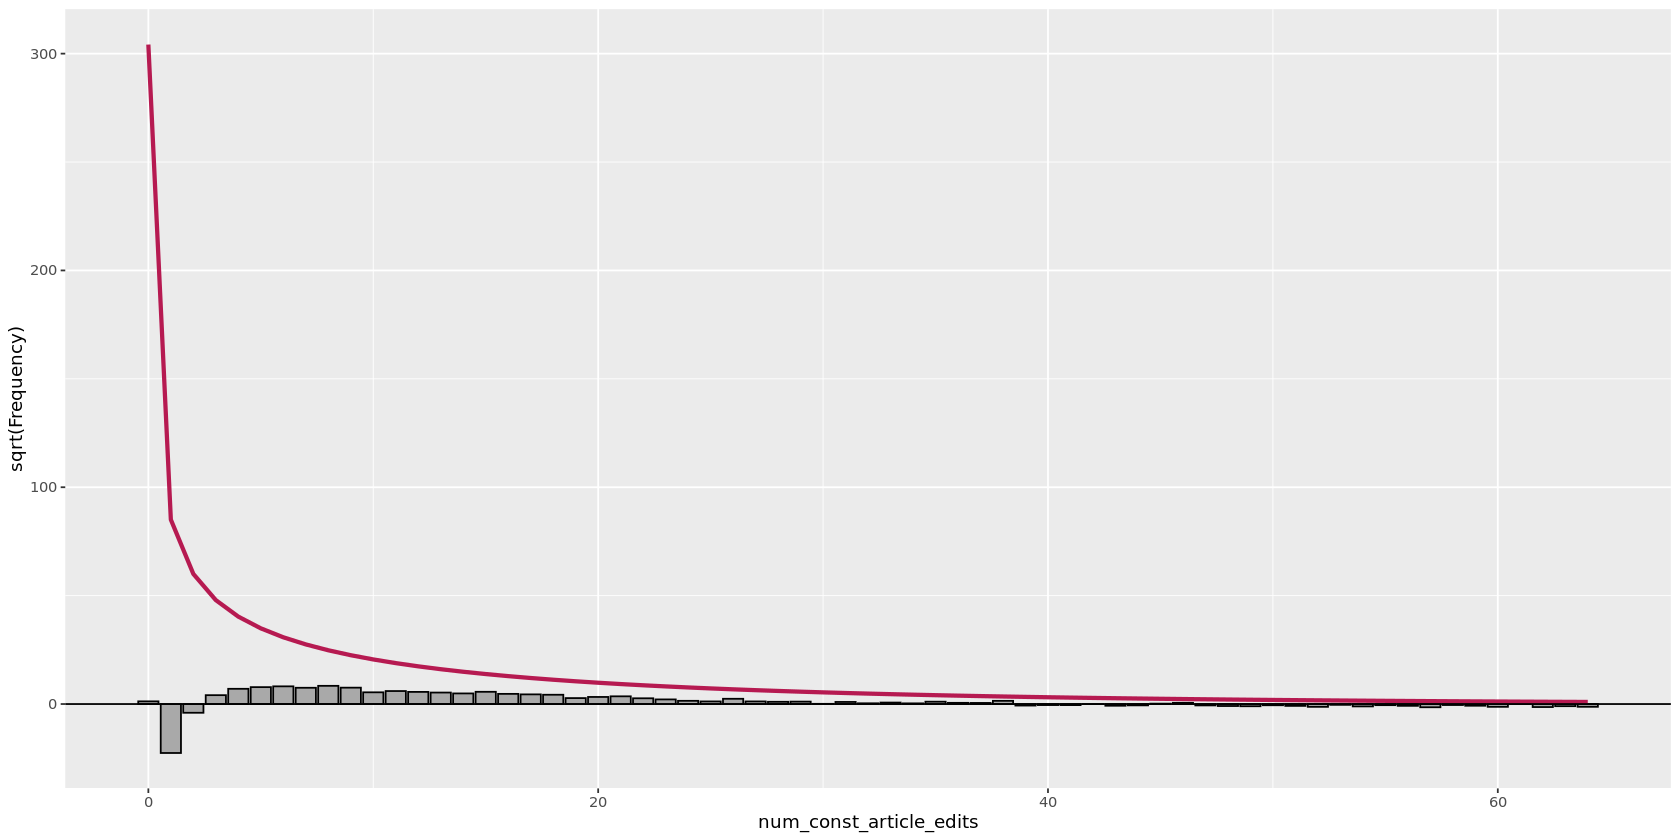

In [27]:
autoplot(rootogram(enwiki.constructive.article.edits.model.1, style = "suspended", plot = FALSE))

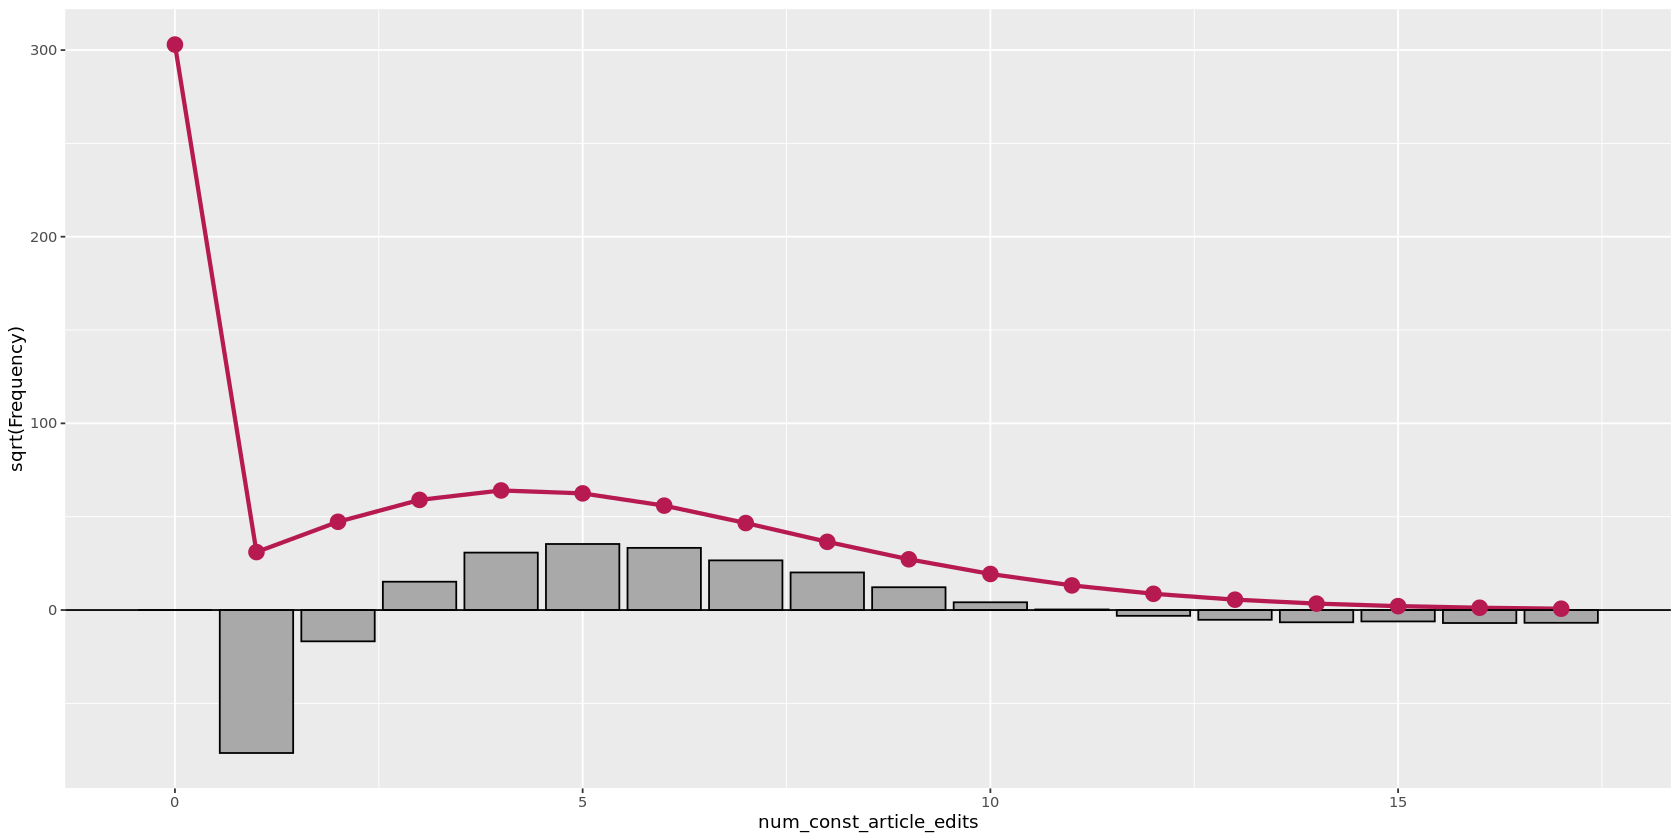

In [26]:
autoplot(rootogram(enwiki.constructive.article.edits.model.2, style = "suspended", plot = FALSE))

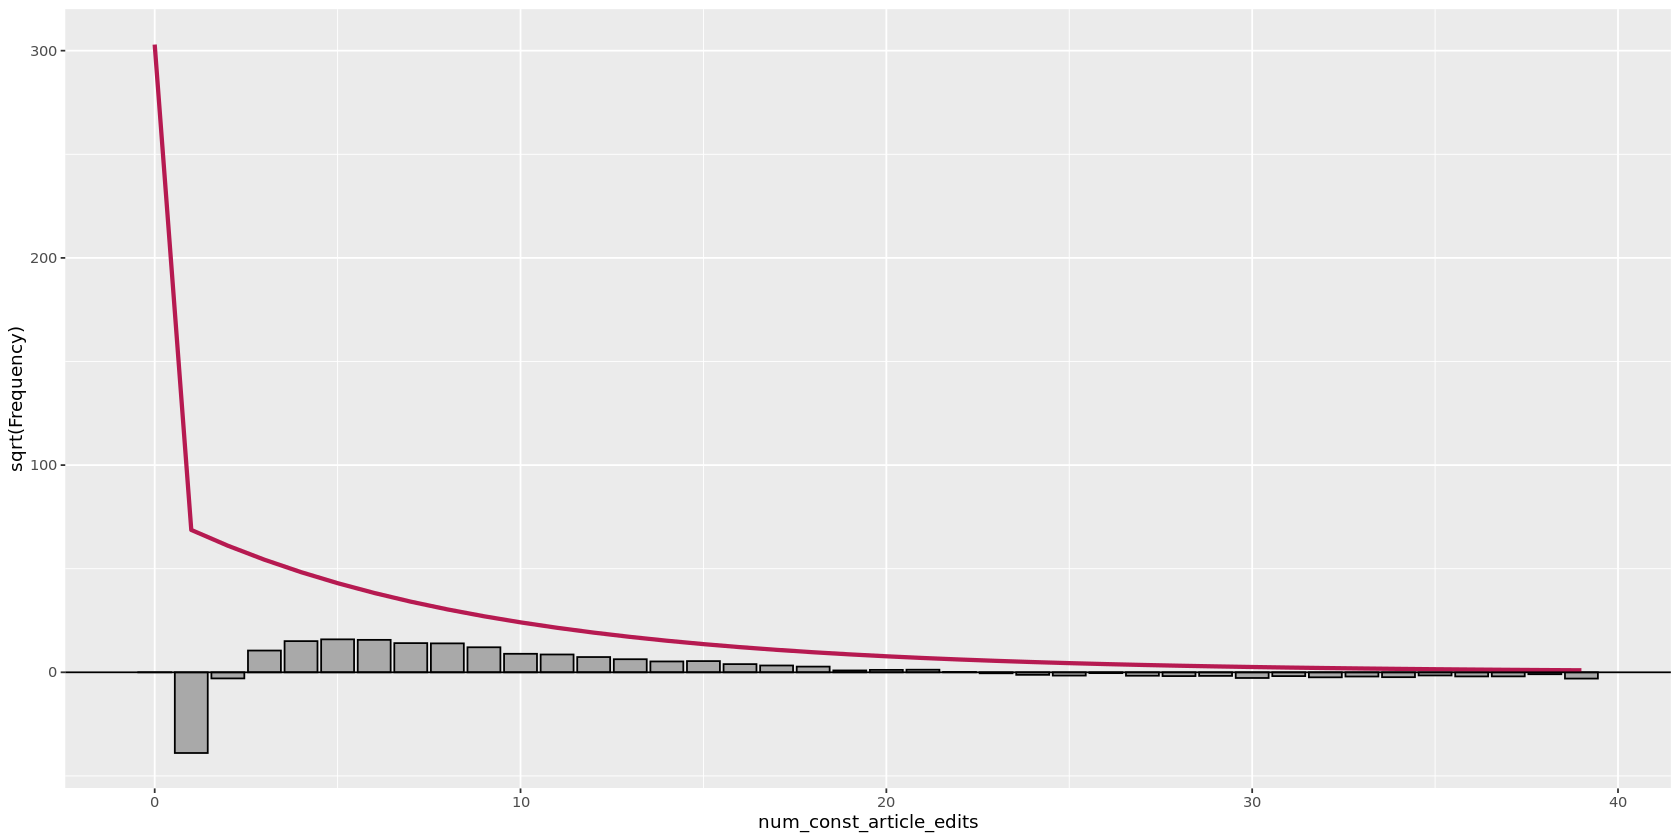

In [42]:
autoplot(rootogram(enwiki.constructive.article.edits.model.5, style = "suspended", plot = FALSE))

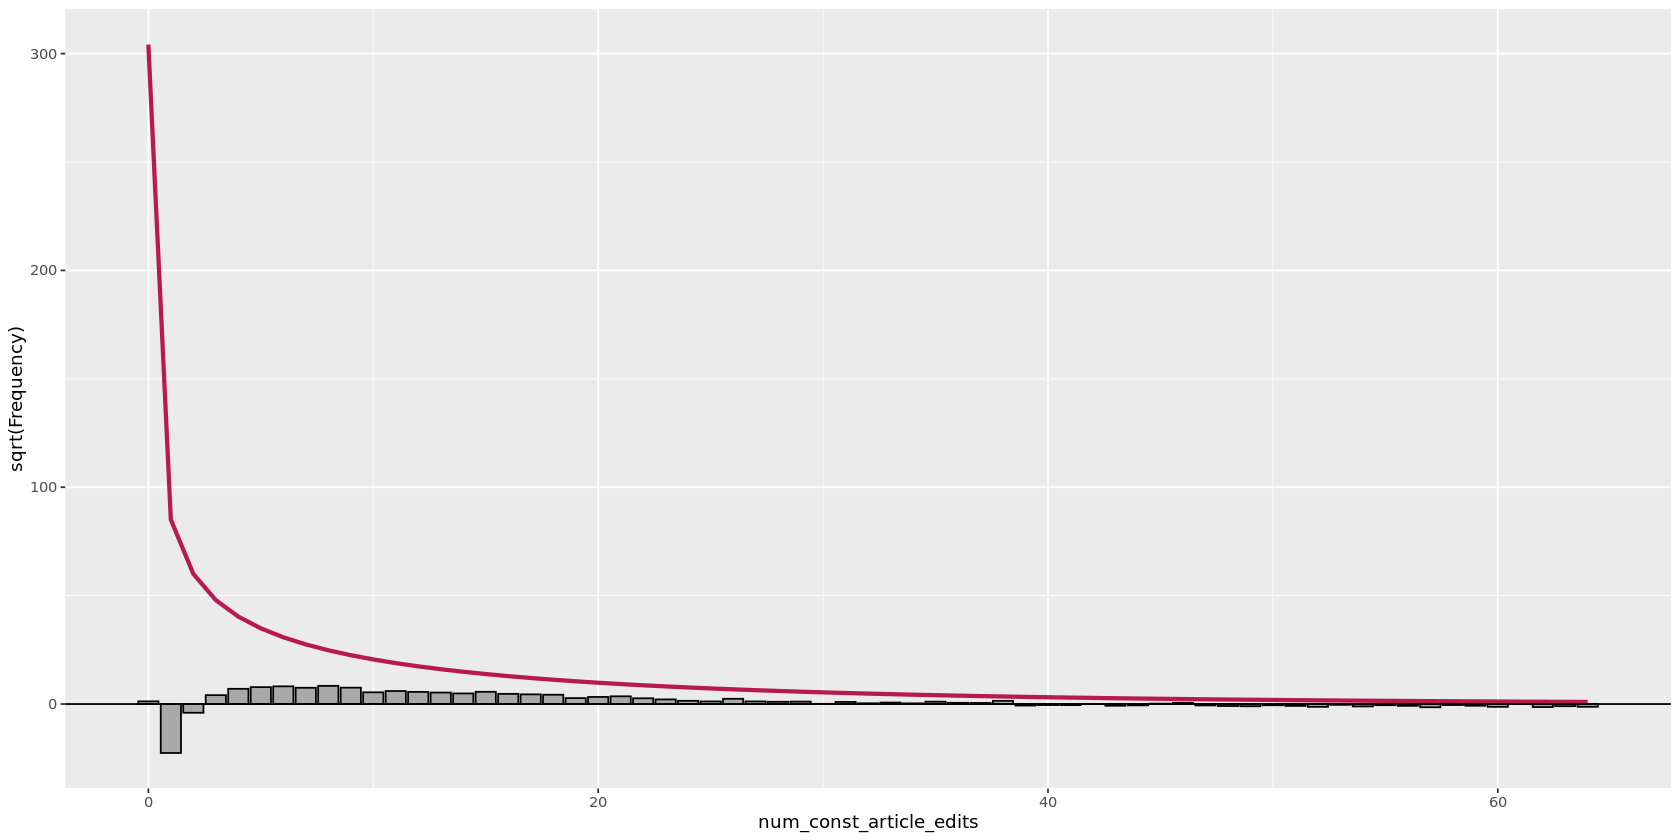

In [47]:
autoplot(rootogram(enwiki.constructive.article.edits.model.6, style = "suspended", plot = FALSE))

In [30]:
table(cut(predict(enwiki.constructive.article.edits.model.1, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
   114512         0         0         0         0         0         0         0 
(0.8,0.9]   (0.9,1] 
        0         0 

In [31]:
table(cut(predict(enwiki.constructive.article.edits.model.2, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
        0         0         0         0         0         0         0     71998 
(0.8,0.9]   (0.9,1] 
    42514         0 

In [34]:
table(cut(predict(enwiki.constructive.article.edits.model.3, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
   114512         0         0         0         0         0         0         0 
(0.8,0.9]   (0.9,1] 
        0         0 

In [37]:
table(cut(predict(enwiki.constructive.article.edits.model.4, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
   109788      4724         0         0         0         0         0         0 
(0.8,0.9]   (0.9,1] 
        0         0 

In [41]:
table(cut(predict(enwiki.constructive.article.edits.model.5, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
        0         0         0         0         0         0         0    114512 
(0.8,0.9]   (0.9,1] 
        0         0 

In [60]:
table(cut(predict(enwiki.constructive.article.edits.model.9, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
   114512         0         0         0         0         0         0         0 
(0.8,0.9]   (0.9,1] 
        0         0 

In [61]:
table(cut(predict(enwiki.constructive.article.edits.model.10, type="zero"), breaks=seq(from=0,to=1,by=0.1))) 


  (0,0.1] (0.1,0.2] (0.2,0.3] (0.3,0.4] (0.4,0.5] (0.5,0.6] (0.6,0.7] (0.7,0.8] 
   114512         0         0         0         0         0         0         0 
(0.8,0.9]   (0.9,1] 
        0         0 

After all this, I think the conclusion is that there isn't any significant zero-inflation in English Wikipedia when it comes to edit counts, and that we prefer a model with as few complications as possible. This means we'll move forward with a negative binomial model.

We'll need to make the same comparison between a model with and without zero-inflation for Spanish as well, of course.